In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
import torchvision.models as models
from torchvision.transforms.functional import InterpolationMode
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset,random_split
from collections import Counter
from PIL import Image
import time

# NLP
import nltk
import string
from nltk.corpus import stopwords
from wordcloud import WordCloud

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Image Captioning with PyTorch
#### Dataset: [Flickr 8k](https://www.kaggle.com/datasets/adityajn105/flickr8k)
- 1. Preparing Data
    - [1.1 Image Normalization](#1.1-Image-Normalization)
    - [1.2 Vocabulary & Data Loader](#1.2-Vocabulary-&-Data-Loader)
- 2. Transformer
    - [2.1 Encoder CNN](#2.1-Encoder-CNN)
    - [2.2 Attention](#2.2-Attention)
    - [2.3 Decoder LSTM](#2.3-Decoder-LSTM)
- 3. [Training and Evaluation](#Training-and-Evaluation)
- 4. [Visualizing the Attentions](#Visualizing-the-Attentions)

References:
- [A PyTorch Tutorial to Image Captioning](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning/tree/master)
- [Image Captioning with Attention - Pytorch](https://www.kaggle.com/code/mdteach/image-captioning-with-attention-pytorch)

In [2]:
root_dir = '/kaggle/input/flickr8k'

data = pd.read_csv(root_dir + "/captions.txt")
data.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

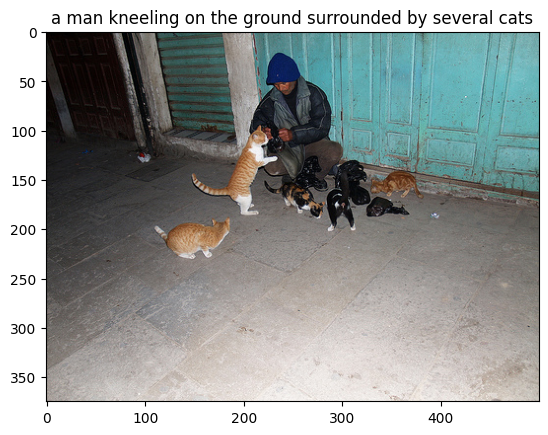

In [3]:
search = 'cats'

image_name = data[data['caption'].str.contains(search, case=False)]['image'].iloc[1]
caption = data[data['image'] == image_name]['caption'].iloc[0]

img = Image.open(root_dir + '/Images/' + image_name)
plt.imshow(img)
plt.title(caption)
plt.show()

### 1. Preparing Data
#### 1.1 Image Normalization

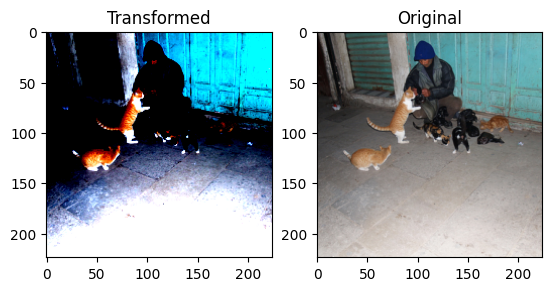

In [4]:
transform = T.Compose([
    T.Resize(232, interpolation=InterpolationMode.BILINEAR),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def inverse_transform(img):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    img *= std
    img += mean

# Plot transformed vs. original
img = Image.open(root_dir + '/Images/' + image_name)
img = transform(img).numpy().transpose((1, 2, 0))

fig, axs = plt.subplots(1, 2)

axs[0].imshow(img)
axs[0].set_title('Transformed')

inverse_transform(img)
axs[1].imshow(img)
axs[1].set_title('Original')

plt.show()

#### 1.2 Vocabulary & Data Loader

In [5]:
class Vocabulary:
    def __init__(self):
        self.itos = {0:"<PAD>", 1:"<SOS>", 2:"<EOS>", 3:"<UNK>"} # index to string (decoder)
        self.stoi = {v: k for k, v in self.itos.items()} # string to index (encoder)
        self.word_freq = Counter()
        
    def __len__(self):
        return len(self.itos)
    
    @staticmethod
    def tokenize(text):
        tokens = nltk.word_tokenize(text)
        tokens = [token.lower() for token in tokens if token not in string.punctuation]
        return tokens
    
    def build_vocab(self, sentences):
        idx = len(self.itos)
        
        for sentence in sentences:
            for word in self.tokenize(sentence):
                self.word_freq[word] += 1
                
                if self.word_freq[word] == 4: # ignore words with less than 4 occurences
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1
    
    def numericalize(self, text):
        tokens = self.tokenize(text)
        tokens = [self.stoi.get(token, self.stoi["<UNK>"]) for token in tokens]
        return tokens

In [6]:
class FlickrDataset(Dataset):
    def __init__(self, transform):
        self.data = pd.read_csv(root_dir + '/captions.txt')
        self.transform = transform
        self.images = self.data["image"]
        self.captions = self.data["caption"]
        self.vocab = Vocabulary()
        self.vocab.build_vocab(self.captions.tolist())
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Normalize image
        img_name = self.images[idx]
        img = Image.open(root_dir + '/Images/' + img_name)
        img = self.transform(img)
        
        # Tokenize caption
        caption = self.captions[idx]
        caption_vec = []
        caption_vec += [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec += [self.vocab.stoi["<EOS>"]]
        
        return img, torch.tensor(caption_vec)

In [7]:
class CapsCollate:
    def __init__(self, pad_idx, batch_first=False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first
    
    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs,dim=0)
        
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)
        return imgs, targets

In [8]:
batch_size = 64
num_workers = 6

dataset = FlickrDataset(transform)

train_size = int(len(dataset)*0.95)
train_dataset, val_dataset = random_split(dataset, [train_size, len(dataset) - train_size])

pad_idx = dataset.vocab.stoi["<PAD>"]

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    collate_fn=CapsCollate(pad_idx=pad_idx, batch_first=True)
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    collate_fn=CapsCollate(pad_idx=pad_idx, batch_first=True)
)

vocab_size = len(dataset.vocab)
vocab_size

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


3435

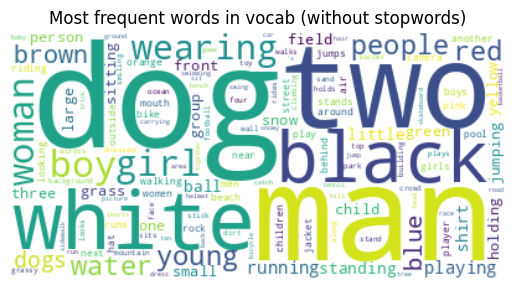

In [9]:
stop_words = set(stopwords.words('english'))

word_freq = {word: freq for word, freq in dataset.vocab.word_freq.items() if word not in stop_words}
wordcloud = WordCloud(background_color ='white').generate_from_frequencies(word_freq)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most frequent words in vocab (without stopwords)")
plt.show()

### 2. Transformer

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

#### 2.1 Encoder CNN
- Input:
    - RGB 224x224 images (3, 224, 224)
- Output:
    - ResNet50 7x7 images with 2048 features (49, 2048)

In [11]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        resnet = models.resnet50(weights="IMAGENET1K_V2")
        # Freeze ResNet
        for p in resnet.parameters():
            p.requires_grad_(False)
        
        # Remove linear and pool layers (since we're not doing classification)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

    def forward(self, images):                        # (None, 3, 224, 224)
        encoder_out = self.resnet(images)             # (None, 2048, 7, 7)
        encoder_out = encoder_out.permute(0, 2, 3, 1) # (None, 7, 7, 2048)
        # Flatten image
        encoder_out = encoder_out.view(encoder_out.size(0), -1, encoder_out.size(-1)) # (None, 196, 2048)
        return encoder_out

#### 2.2 Attention

In [12]:
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attn_dim):
        super(Attention, self).__init__()
        self.attn_dim = attn_dim
        self.encoder_attn = nn.Linear(encoder_dim, attn_dim) # linear layer to transform encoded image
        self.decoder_attn = nn.Linear(decoder_dim, attn_dim) # linear layer to transform decoder's output
        self.full_attn = nn.Linear(attn_dim, 1)              # linear layer to calculate values for softmax
        
    def forward(self, encoder_out, decoder_hidden):
        attn1 = self.encoder_attn(encoder_out)    # (None, num_pixels, attn_dim)
        attn2 = self.decoder_attn(decoder_hidden) # (None, attn_dim)
        
        combined_states = torch.tanh(attn1 + attn2.unsqueeze(1)) # (None, num_pixels, attn_dim)
        attn_scores = self.full_attn(combined_states)            # (None, num_pixels, 1)
        attn_scores = attn_scores.squeeze(2)                     # (None, num_pixels)
        
        alpha = F.softmax(attn_scores, dim=1) # (None, num_pixels)
        
        attn_weights = encoder_out * alpha.unsqueeze(2) # (None, num_pixels, encoder_out)
        attn_weights = attn_weights.sum(dim=1)          # (None, num_pixels)
        
        return attn_weights, alpha

#### 2.3 Decoder LSTM

In [13]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, attn_dim, encoder_dim, decoder_dim, dropout):
        super(Decoder, self).__init__()
        self.vocab_size = vocab_size
        self.attn_dim = attn_dim
        self.decoder_dim = decoder_dim
        
        self.attention = Attention(encoder_dim, decoder_dim, attn_dim)
        
        self.embedding = nn.Embedding(vocab_size, embed_dim)        
        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        self.lstm_cell = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        
        self.fc = nn.Linear(decoder_dim, vocab_size)
        self.dropout = nn.Dropout(p=dropout)
    
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out) # (None, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c
    
    def forward(self, encoder_out, captions):
        batch_size = captions.size(0)
        num_pixels = encoder_out.size(1)
        seq_length = len(captions[0]) - 1 # Exclude <END>
        
        # Embeddings
        embeddings = self.embedding(captions)
        
        # Initialize LSTM state
        h, c = self.init_hidden_state(encoder_out) # (None, decoder_dim)
        
        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length, num_pixels).to(device)
                
        for t in range(seq_length):
            attn_weights, alpha = self.attention(encoder_out, h)
            lstm_input = torch.cat((embeddings[:, t], attn_weights), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            
            output = self.fc(self.dropout(h))
            
            preds[:, t] = output
            alphas[:, t] = alpha
        
        return preds, alphas
    
    def generate_caption(self, encoder_out, vocab, max_len=20):
        batch_size = encoder_out.size(0)
        h, c = self.init_hidden_state(encoder_out) # (None, decoder_dim)
        
        word = torch.tensor(vocab.stoi['<SOS>']).view(1,-1).to(device)
        embeds = self.embedding(word)
        
        alphas = []
        captions = []
        for i in range(max_len):
            context, alpha = self.attention(encoder_out, h)
            
            alphas.append(alpha.cpu().detach().numpy())
            
            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fc(self.dropout(h))
            output = output.view(batch_size, -1)
            
            predicted_word_idx = output.argmax(dim=1)
            captions.append(predicted_word_idx.item())
            
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break
                
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
        
        caps = [vocab.itos[idx] for idx in captions]
        return caps, alphas

#### 2.4 Final model

In [14]:
class EncoderDecoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, attn_dim, encoder_dim, decoder_dim, dropout):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder(vocab_size, embed_dim, attn_dim, encoder_dim, decoder_dim, dropout)
        
    def forward(self, images, captions):
        encoder_out = self.encoder(images)
        outputs = self.decoder(encoder_out, captions)
        return outputs

In [15]:
# Hyperparameters
embed_dim = 256
attn_dim = 256
encoder_dim = 2048
decoder_dim = 512
dropout = 0.5
learning_rate = 1e-3

model = EncoderDecoder(vocab_size, embed_dim, attn_dim, encoder_dim, decoder_dim, dropout).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 164MB/s]


## Training and Evaluation

In [17]:
epochs = 4
print_every = 20

for epoch in range(epochs):
    start_epoch = time.time()
    # Training
    model.train()
    start_step = time.time()
    for i, (image, captions) in enumerate(train_loader):
        image, captions = image.to(device), captions.to(device)

        optimizer.zero_grad()

        outputs, attentions = model(image, captions)

        targets = captions[:, 1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))

        loss.backward()
        optimizer.step()

        if (i + 1) % print_every == 0:
            print(f'Epoch {epoch + 1}/{epochs}, Step {i + 1}/{len(train_loader)}, Train loss: {loss.item():.4f}, Time: {time.time() - start_step:.2f}s')
            start_step = time.time()
            
    # Validation
    model.eval()
    validation_loss = 0
    with torch.no_grad():
        for i, (image, captions) in enumerate(val_loader):
            image, captions = image.to(device), captions.to(device)
            outputs, attentions = model(image, captions)
            targets = captions[:, 1:]
            loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
            validation_loss += loss.item()

    validation_loss /= len(val_loader)

    end_epoch = time.time()
    print(f'Epoch {epoch + 1} completed in {(end_epoch - start_epoch) / 60:.2f}m')
    print(f'Validation loss: {validation_loss:.4f}')

Epoch 1/4, Step 20/601, Train loss: 3.2534, Time: 5.66s
Epoch 1/4, Step 40/601, Train loss: 3.0141, Time: 4.25s
Epoch 1/4, Step 60/601, Train loss: 3.2051, Time: 4.70s
Epoch 1/4, Step 80/601, Train loss: 3.2104, Time: 4.30s
Epoch 1/4, Step 100/601, Train loss: 2.9025, Time: 4.21s
Epoch 1/4, Step 120/601, Train loss: 3.1196, Time: 4.13s
Epoch 1/4, Step 140/601, Train loss: 2.9657, Time: 4.14s
Epoch 1/4, Step 160/601, Train loss: 3.1181, Time: 4.21s
Epoch 1/4, Step 180/601, Train loss: 3.2209, Time: 4.08s
Epoch 1/4, Step 200/601, Train loss: 2.9662, Time: 4.45s
Epoch 1/4, Step 220/601, Train loss: 2.9999, Time: 4.43s
Epoch 1/4, Step 240/601, Train loss: 2.8622, Time: 4.15s
Epoch 1/4, Step 260/601, Train loss: 2.7734, Time: 4.18s
Epoch 1/4, Step 280/601, Train loss: 2.9867, Time: 4.01s
Epoch 1/4, Step 300/601, Train loss: 3.1823, Time: 4.27s
Epoch 1/4, Step 320/601, Train loss: 2.9727, Time: 4.20s
Epoch 1/4, Step 340/601, Train loss: 3.1692, Time: 4.20s
Epoch 1/4, Step 360/601, Train loss

## Visualizing the Attentions

In [18]:
def unnormalize(img):
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224
    img[2] = img[2] * 0.225
    img[0] += 0.485
    img[1] += 0.456
    img[2] += 0.406

def get_caps_from(features_tensors):
    model.eval()
    with torch.no_grad():
        encoder_out = model.encoder(features_tensors.to(device))
        caps, alphas = model.decoder.generate_caption(encoder_out, dataset.vocab)
        caps = caps[:-1] # Remove <EOS>
        caption = ' '.join(caps)
        
        # Show image
        img = features_tensors[0]
        unnormalize(img)
        img = img.numpy().transpose((1, 2, 0))
        
        plt.imshow(img)
        plt.title(caption)
        plt.axis('off')
        plt.show()
    
    return caps, alphas

def plot_attention(img, result, attention_plot):
    unnormalize(img)
    
    img = img.numpy().transpose((1, 2, 0))
    temp_image = img

    fig = plt.figure(figsize=(15, 15))

    len_result = len(result)
    for l in range(len_result):
        temp_att = attention_plot[l].reshape(7, 7)

        ax = fig.add_subplot(len_result // 2, len_result // 2, l + 1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, alpha=0.8, extent=img.get_extent(), interpolation='gaussian')
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()

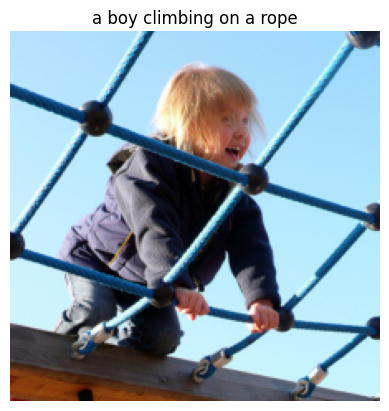

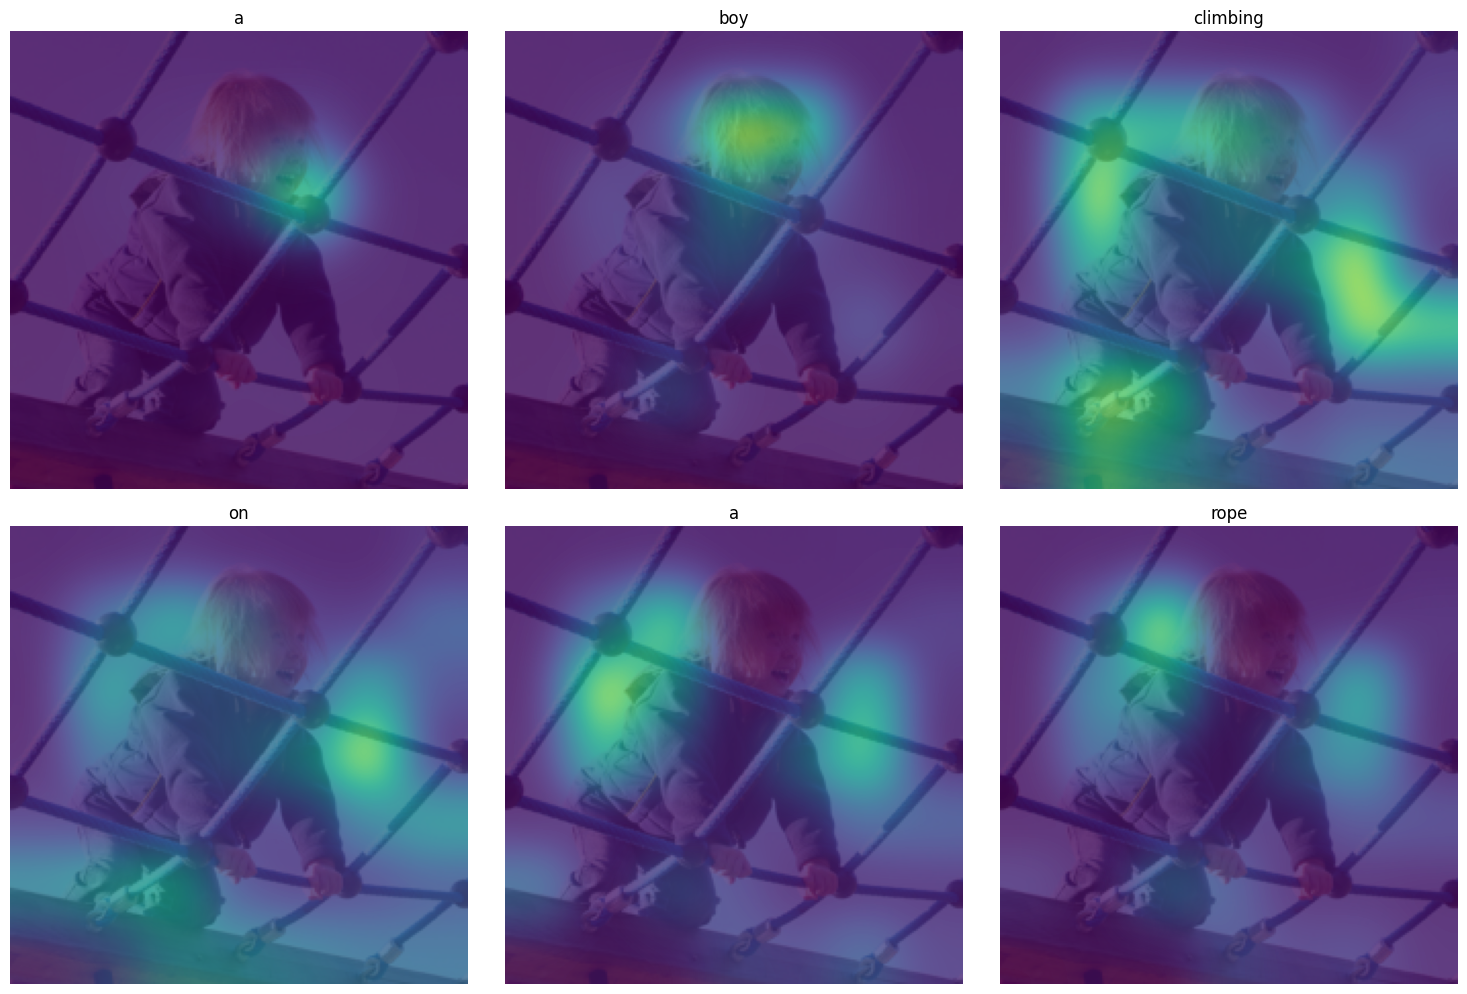

In [39]:
# Show any validation image
dataiter = iter(val_loader)
images, _ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps, alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

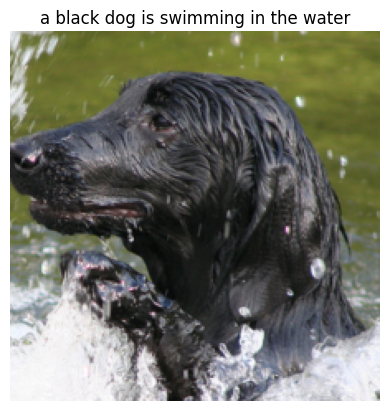

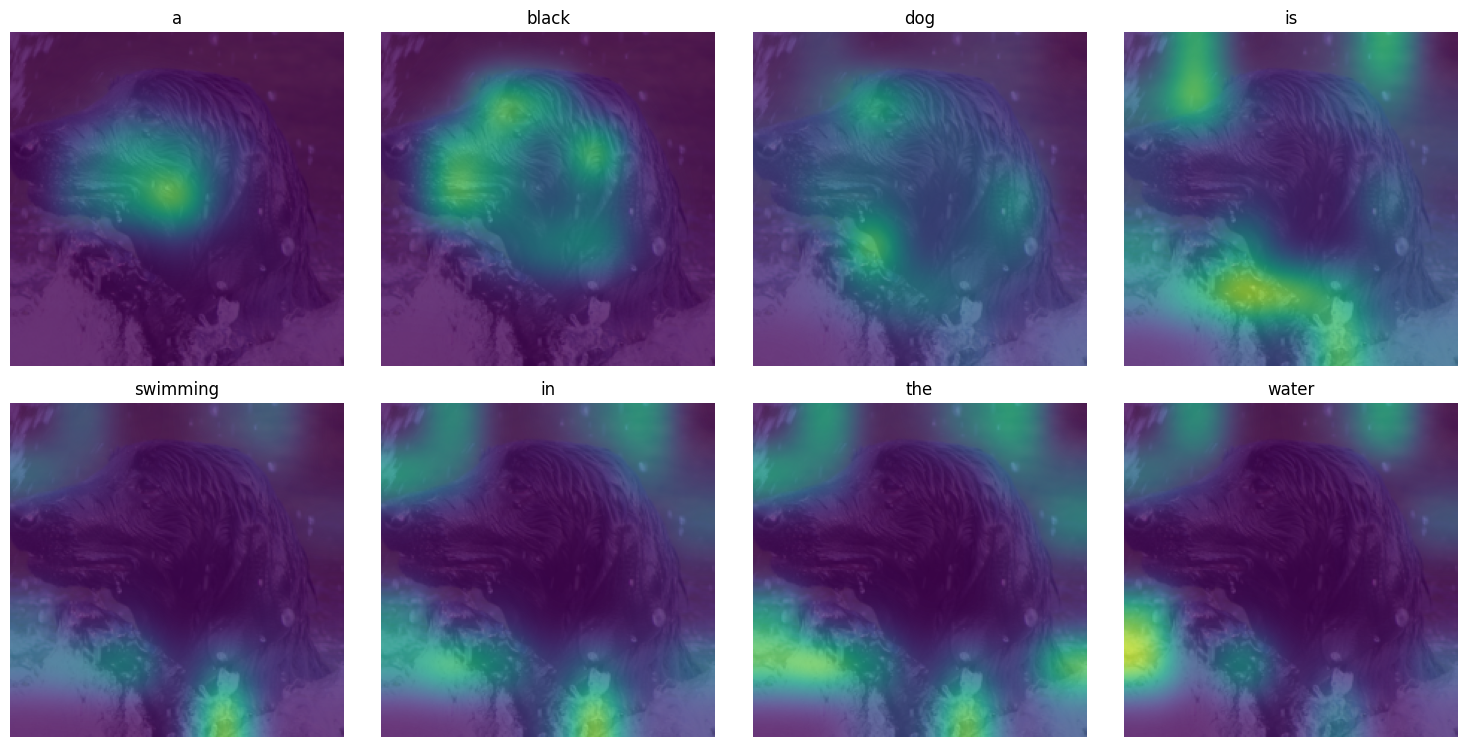

In [61]:
# Show any validation image
dataiter = iter(val_loader)
images, _ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps, alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)